In [1]:
!pip install pycocotools

In [57]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import torch
import torch.utils.data as data
from vocabulary import Vocabulary
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import numpy as np
import pickle
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import math

# Encoder, Decoder, Generator, Discriminator

In [58]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.train_params = list(self.embed.parameters())

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.train_params = list(self.parameters())
    
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding_layer(captions)
        embed = torch.cat((features.unsqueeze(1), embed), dim = 1)
        lstm_outputs, _ = self.lstm(embed)
        out = self.linear(lstm_outputs)
        
        return out

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output_sentence = []
        for i in range(max_len):
            lstm_outputs, states = self.lstm(inputs, states)
            lstm_outputs = lstm_outputs.squeeze(1)
            out = self.linear(lstm_outputs)
            last_pick = out.max(1)[1]
            output_sentence.append(last_pick.item())
            inputs = self.embedding_layer(last_pick).unsqueeze(1)
        
        return output_sentence
    
    def beam_sample(self, inputs, states=None, max_len=20, k=1):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        possible_seq = [(1, inputs, states)]
        for i in range(max_len):
            to_pick = []
            for probs,seq,states in possible_seq:
                inputs = self.embedding_layer(seq[-1])
                lstm_outputs, states = self.lstm(inputs, states)
                out = self.linear(lstm_outputs).squeeze(0)
                sorted_out, indices = torch.sort(out, 1)
                
                for j in range(k):
                    to_pick.append((probs + nn.functional.log_softmax(sorted_out[i]), inputs + [indices[i]], states) )
                 
            to_pick.sort(reverse=True)
            possible_seq = to_pick[:k]
            
        return to_pick[0]


class EncoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, context_size, num_layers=1):
        super().__init__()
        #self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, context_size)
        self.train_params = list(self.parameters())
    
    def forward(self, captions):
        lstm_outputs, _ = self.lstm(captions)
        out = self.linear(lstm_outputs[:,-1,:].squeeze(1))
        return out

    
class Generator(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, context_size, num_layers=1):
        super(Generator, self).__init__()
        self.cnn = EncoderCNN(context_size)
        self.rnn = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_layers)
        self.train_params = self.cnn.train_params + self.rnn.train_params 

    def forward(self, images, captions):
        features = self.cnn(images)
        output = self.rnn(features, captions)
        return output, features


class Discriminator(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, context_size, num_layers=1):
        super(Discriminator, self).__init__()
        self.embed = nn.Linear(vocab_size, embed_size)
        self.rnn = EncoderRNN(embed_size, hidden_size, vocab_size, context_size, num_layers=num_layers)
        #self.crit = nn.CosineSimilarity(dim=0, eps=1e-6)
        self.train_params = list(self.embed.parameters()) + self.rnn.train_params
        

    def forward(self, image_feat, captions):
        bs = image_feat.size(0)
        embed = self.embed(captions)
        cap_feat = self.rnn(embed)
            
        return cap_feat

# Data loader

In [59]:
# get_loader function
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join('datasets/train2014') # change directory here
        annotations_file = os.path.join('datasets/annotations/captions_train2014.json') #Change directory here
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join('datasets/val2014/') #Change directory here
        annotations_file = os.path.join('datasets/annotations/captions_val2014.json') #Change directory here

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

# Coco Dataset 

In [60]:
class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            # path = self.paths[index]
            ann_id = self.ids[index]
            img_id = self.coco.anns[ann_id]['image_id']
            img_path = self.coco.loadImgs(img_id)[0]['file_name']
            caption = self.coco.anns[ann_id]['caption']

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, img_path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            return orig_image, image, os.path.join(self.img_folder, img_path), caption, img_id

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

# Main implementation

In [9]:
# Some parameters for the model

batch_size = 8        # batch size
vocab_threshold = 5 #original is 4       # minimum word count threshold
vocab_from_file = True # if True, load existing vocab file
embed_size = 300   #original is 300        # dimensionality of image and word embeddings
hidden_size = 512  # original is 512        # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 500             # determines frequency of saving model weights
print_every = 100         # determines window for printing average loss

In [10]:
# transform the image
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [11]:
# Create the data loader

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.65s)
creating index...


  0%|▏                                                                          | 947/414113 [00:00<00:43, 9401.35it/s]

index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 414113/414113 [00:38<00:00, 10781.34it/s]


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

In [13]:
vocab_size = len(data_loader.dataset.vocab)
vocab_size

8856

In [14]:
generator = Generator(embed_size, hidden_size, vocab_size, embed_size)
discriminator = Discriminator(embed_size, hidden_size, vocab_size, embed_size)

In [15]:
gen_params = list(generator.parameters())
disc_params = list(discriminator.parameters())
params = generator.train_params + discriminator.train_params

In [16]:
optimizer = torch.optim.Adam(params = params, lr = 0.0001)

In [61]:
generator.to(device)
discriminator.to(device)

#Cosine Similarity
cosineSim = nn.CosineSimilarity(dim=0, eps=1e-6)
# Generator Criterion
criterion_A = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Discriminator Criterion
pos_weight = torch.Tensor([batch_size-1])
criterion_B = nn.BCEWithLogitsLoss(pos_weight).cuda()

# Generator Training

In [24]:
    generator.train()
    discriminator.train()


    for epoch in range(1, num_epochs+1):
        
        for i_step in range(1, total_step+1):
            
            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler
            
            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)
            
            # Zero the gradients.
            generator.zero_grad()
            discriminator.zero_grad()
            
            # Pass the inputs through the CNN-RNN model.
            out, img_feats = generator(images, captions)
            
            rho = 0.25
            if random.random() < rho:
                gen_captions = nn.functional.softmax(out)
            else:
                gen_captions = nn.functional.gumbel_softmax(out, hard=True)
                    
            cap_feats = discriminator(img_feats, gen_captions).to(device)
            
            max_loss_1 = 0
            max_loss_2 = 0
            pos_pair_term = cosineSim(cap_feats[0], img_feats[0])
            for i in range(1,batch_size):
                max_loss_1 += max(0, 1 - pos_pair_term + cosineSim(cap_feats[0], img_feats[i]))
                max_loss_2 += max(0, 1 - pos_pair_term + cosineSim(cap_feats[i], img_feats[0]))
            
            
            
            # Calculate the batch loss.
            loss_A = criterion_A(out.view(-1, vocab_size), captions.view(-1))
            loss_B = (max_loss_1 + max_loss_2)/(batch_size-1)
            
            B_weight = 0.5
            loss = loss_A + B_weight*loss_B
            
            # Backward pass.
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
                
            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: (%.4f, %.4f, %.4f), Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), loss_A.item(), B_weight*loss_B.item(), np.exp(loss.item()))
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
                
            # Save the weights.
            if i_step % save_every == 0:
                torch.save(generator.state_dict(), os.path.join('scratch', 'models',f'coop-generator-{epoch}-{i_step}.pkl'))
                torch.save(discriminator.state_dict(), os.path.join('scratch', 'models',f'coop-discriminator-{epoch}-{i_step}.pkl'))


Epoch [1/3], Step [15/51765], Loss: (8.8422, 8.8416, 0.0006), Perplexity: 6920.2221

C:\Users\chris\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/3], Step [100/51765], Loss: (4.7381, 4.7376, 0.0005), Perplexity: 114.2127
Epoch [1/3], Step [200/51765], Loss: (4.6195, 4.6190, 0.0005), Perplexity: 101.4438
Epoch [1/3], Step [300/51765], Loss: (4.1741, 4.1736, 0.0005), Perplexity: 64.98227
Epoch [1/3], Step [400/51765], Loss: (4.4652, 4.4647, 0.0005), Perplexity: 86.93412
Epoch [1/3], Step [500/51765], Loss: (4.1146, 4.1141, 0.0005), Perplexity: 61.22913
Epoch [1/3], Step [600/51765], Loss: (4.8449, 4.8444, 0.0005), Perplexity: 127.0888
Epoch [1/3], Step [700/51765], Loss: (3.7552, 3.7547, 0.0005), Perplexity: 42.74255
Epoch [1/3], Step [800/51765], Loss: (3.9297, 3.9292, 0.0005), Perplexity: 50.89269
Epoch [1/3], Step [900/51765], Loss: (4.2036, 4.2031, 0.0005), Perplexity: 66.92481
Epoch [1/3], Step [1000/51765], Loss: (3.9347, 3.9342, 0.0005), Perplexity: 51.1485
Epoch [1/3], Step [1100/51765], Loss: (3.6909, 3.6904, 0.0005), Perplexity: 40.08122
Epoch [1/3], Step [1200/51765], Loss: (3.8344, 3.8339, 0.0005), Perplexity:

Epoch [1/3], Step [19400/51765], Loss: (2.6653, 2.6648, 0.0005), Perplexity: 14.3726
Epoch [1/3], Step [19500/51765], Loss: (3.1682, 3.1677, 0.0005), Perplexity: 23.7646
Epoch [1/3], Step [19600/51765], Loss: (2.8161, 2.8156, 0.0005), Perplexity: 16.7123
Epoch [1/3], Step [19700/51765], Loss: (1.9811, 1.9806, 0.0005), Perplexity: 7.25083
Epoch [1/3], Step [19800/51765], Loss: (2.4262, 2.4257, 0.0005), Perplexity: 11.3155
Epoch [1/3], Step [19900/51765], Loss: (2.6404, 2.6398, 0.0005), Perplexity: 14.0184
Epoch [1/3], Step [20000/51765], Loss: (2.8999, 2.8994, 0.0005), Perplexity: 18.1725
Epoch [1/3], Step [20100/51765], Loss: (2.8587, 2.8582, 0.0005), Perplexity: 17.4395
Epoch [1/3], Step [20200/51765], Loss: (3.0915, 3.0909, 0.0005), Perplexity: 22.0093
Epoch [1/3], Step [20300/51765], Loss: (3.4466, 3.4461, 0.0005), Perplexity: 31.3933
Epoch [1/3], Step [20400/51765], Loss: (3.0052, 3.0047, 0.0005), Perplexity: 20.1909
Epoch [1/3], Step [20500/51765], Loss: (2.5561, 2.5556, 0.0005), 

Epoch [1/3], Step [38600/51765], Loss: (1.8886, 1.8880, 0.0005), Perplexity: 6.60998
Epoch [1/3], Step [38700/51765], Loss: (2.1934, 2.1929, 0.0005), Perplexity: 8.96566
Epoch [1/3], Step [38800/51765], Loss: (1.8749, 1.8743, 0.0005), Perplexity: 6.51997
Epoch [1/3], Step [38900/51765], Loss: (2.7013, 2.7008, 0.0005), Perplexity: 14.8992
Epoch [1/3], Step [39000/51765], Loss: (2.6088, 2.6083, 0.0005), Perplexity: 13.5834
Epoch [1/3], Step [39100/51765], Loss: (2.4496, 2.4490, 0.0005), Perplexity: 11.5833
Epoch [1/3], Step [39200/51765], Loss: (2.4549, 2.4544, 0.0005), Perplexity: 11.6457
Epoch [1/3], Step [39300/51765], Loss: (3.0528, 3.0522, 0.0005), Perplexity: 21.1741
Epoch [1/3], Step [39400/51765], Loss: (2.3999, 2.3993, 0.0005), Perplexity: 11.0218
Epoch [1/3], Step [39500/51765], Loss: (1.9713, 1.9708, 0.0005), Perplexity: 7.18019
Epoch [1/3], Step [39600/51765], Loss: (2.2462, 2.2456, 0.0005), Perplexity: 9.45149
Epoch [1/3], Step [39700/51765], Loss: (2.5783, 2.5778, 0.0005), 

Epoch [2/3], Step [6200/51765], Loss: (2.2824, 2.2819, 0.0005), Perplexity: 9.80076
Epoch [2/3], Step [6300/51765], Loss: (2.6747, 2.6742, 0.0005), Perplexity: 14.5085
Epoch [2/3], Step [6400/51765], Loss: (2.7076, 2.7071, 0.0005), Perplexity: 14.9937
Epoch [2/3], Step [6500/51765], Loss: (3.3032, 3.3027, 0.0005), Perplexity: 27.1999
Epoch [2/3], Step [6600/51765], Loss: (2.2098, 2.2093, 0.0005), Perplexity: 9.11428
Epoch [2/3], Step [6700/51765], Loss: (2.3944, 2.3939, 0.0005), Perplexity: 10.9620
Epoch [2/3], Step [6800/51765], Loss: (1.8383, 1.8378, 0.0005), Perplexity: 6.28600
Epoch [2/3], Step [6900/51765], Loss: (1.9075, 1.9069, 0.0005), Perplexity: 6.73626
Epoch [2/3], Step [7000/51765], Loss: (1.8855, 1.8850, 0.0005), Perplexity: 6.58975
Epoch [2/3], Step [7100/51765], Loss: (1.8002, 1.7997, 0.0005), Perplexity: 6.05107
Epoch [2/3], Step [7200/51765], Loss: (2.1567, 2.1561, 0.0005), Perplexity: 8.64220
Epoch [2/3], Step [7300/51765], Loss: (2.3912, 2.3906, 0.0005), Perplexity: 

Epoch [2/3], Step [25400/51765], Loss: (1.7296, 1.7290, 0.0005), Perplexity: 5.63810
Epoch [2/3], Step [25500/51765], Loss: (2.3158, 2.3153, 0.0005), Perplexity: 10.1332
Epoch [2/3], Step [25600/51765], Loss: (1.8340, 1.8334, 0.0005), Perplexity: 6.258681
Epoch [2/3], Step [25700/51765], Loss: (2.0742, 2.0737, 0.0005), Perplexity: 7.95827
Epoch [2/3], Step [25800/51765], Loss: (2.1847, 2.1842, 0.0005), Perplexity: 8.88837
Epoch [2/3], Step [25900/51765], Loss: (2.5400, 2.5394, 0.0005), Perplexity: 12.6796
Epoch [2/3], Step [26000/51765], Loss: (2.1320, 2.1314, 0.0005), Perplexity: 8.43146
Epoch [2/3], Step [26100/51765], Loss: (2.4237, 2.4231, 0.0005), Perplexity: 11.2871
Epoch [2/3], Step [26200/51765], Loss: (1.7894, 1.7889, 0.0005), Perplexity: 5.98618
Epoch [2/3], Step [26300/51765], Loss: (2.0646, 2.0641, 0.0005), Perplexity: 7.88247
Epoch [2/3], Step [26400/51765], Loss: (1.5795, 1.5790, 0.0005), Perplexity: 4.85281
Epoch [2/3], Step [26500/51765], Loss: (1.7879, 1.7873, 0.0006),

Epoch [2/3], Step [44600/51765], Loss: (2.3312, 2.3307, 0.0005), Perplexity: 10.2904
Epoch [2/3], Step [44700/51765], Loss: (2.3241, 2.3236, 0.0005), Perplexity: 10.2177
Epoch [2/3], Step [44800/51765], Loss: (2.1601, 2.1595, 0.0005), Perplexity: 8.67183
Epoch [2/3], Step [44900/51765], Loss: (1.7846, 1.7841, 0.0005), Perplexity: 5.95727
Epoch [2/3], Step [45000/51765], Loss: (1.7188, 1.7182, 0.0005), Perplexity: 5.57775
Epoch [2/3], Step [45100/51765], Loss: (2.2076, 2.2070, 0.0005), Perplexity: 9.09356
Epoch [2/3], Step [45200/51765], Loss: (2.1002, 2.0996, 0.0005), Perplexity: 8.16775
Epoch [2/3], Step [45300/51765], Loss: (2.0963, 2.0957, 0.0005), Perplexity: 8.13572
Epoch [2/3], Step [45400/51765], Loss: (2.4506, 2.4501, 0.0005), Perplexity: 11.5952
Epoch [2/3], Step [45500/51765], Loss: (2.3127, 2.3121, 0.0005), Perplexity: 10.1012
Epoch [2/3], Step [45600/51765], Loss: (1.9361, 1.9355, 0.0005), Perplexity: 6.93165
Epoch [2/3], Step [45700/51765], Loss: (1.8065, 1.8059, 0.0005), 

Epoch [3/3], Step [12200/51765], Loss: (2.6409, 2.6404, 0.0005), Perplexity: 14.0263
Epoch [3/3], Step [12300/51765], Loss: (1.7427, 1.7422, 0.0005), Perplexity: 5.71289
Epoch [3/3], Step [12400/51765], Loss: (2.2674, 2.2668, 0.0005), Perplexity: 9.65415
Epoch [3/3], Step [12500/51765], Loss: (2.0971, 2.0966, 0.0005), Perplexity: 8.14283
Epoch [3/3], Step [12600/51765], Loss: (2.5453, 2.5448, 0.0005), Perplexity: 12.7475
Epoch [3/3], Step [12700/51765], Loss: (2.0981, 2.0976, 0.0005), Perplexity: 8.15093
Epoch [3/3], Step [12800/51765], Loss: (1.9705, 1.9700, 0.0005), Perplexity: 7.17434
Epoch [3/3], Step [12900/51765], Loss: (2.5112, 2.5107, 0.0006), Perplexity: 12.3203
Epoch [3/3], Step [13000/51765], Loss: (2.0417, 2.0411, 0.0005), Perplexity: 7.70359
Epoch [3/3], Step [13100/51765], Loss: (2.0306, 2.0300, 0.0005), Perplexity: 7.61843
Epoch [3/3], Step [13200/51765], Loss: (2.9616, 2.9611, 0.0005), Perplexity: 19.3295
Epoch [3/3], Step [13300/51765], Loss: (2.5191, 2.5185, 0.0005), 

Epoch [3/3], Step [31400/51765], Loss: (2.2907, 2.2902, 0.0005), Perplexity: 9.88237
Epoch [3/3], Step [31500/51765], Loss: (2.2165, 2.2159, 0.0005), Perplexity: 9.17512
Epoch [3/3], Step [31600/51765], Loss: (2.3675, 2.3670, 0.0005), Perplexity: 10.6707
Epoch [3/3], Step [31700/51765], Loss: (2.1189, 2.1183, 0.0005), Perplexity: 8.32191
Epoch [3/3], Step [31800/51765], Loss: (3.4411, 3.4406, 0.0005), Perplexity: 31.2223
Epoch [3/3], Step [31900/51765], Loss: (2.1826, 2.1821, 0.0005), Perplexity: 8.86937
Epoch [3/3], Step [32000/51765], Loss: (1.9005, 1.8999, 0.0005), Perplexity: 6.68909
Epoch [3/3], Step [32100/51765], Loss: (1.9421, 1.9415, 0.0005), Perplexity: 6.97327
Epoch [3/3], Step [32200/51765], Loss: (2.0576, 2.0571, 0.0005), Perplexity: 7.82742
Epoch [3/3], Step [32300/51765], Loss: (1.9449, 1.9443, 0.0005), Perplexity: 6.99281
Epoch [3/3], Step [32400/51765], Loss: (1.6855, 1.6850, 0.0005), Perplexity: 5.39520
Epoch [3/3], Step [32500/51765], Loss: (2.4838, 2.4833, 0.0005), 

Epoch [3/3], Step [50600/51765], Loss: (2.0915, 2.0909, 0.0005), Perplexity: 8.09677
Epoch [3/3], Step [50700/51765], Loss: (1.8279, 1.8273, 0.0005), Perplexity: 6.22054
Epoch [3/3], Step [50800/51765], Loss: (2.5674, 2.5668, 0.0005), Perplexity: 13.0313
Epoch [3/3], Step [50900/51765], Loss: (2.4838, 2.4833, 0.0006), Perplexity: 11.9868
Epoch [3/3], Step [51000/51765], Loss: (2.1118, 2.1113, 0.0005), Perplexity: 8.26333
Epoch [3/3], Step [51100/51765], Loss: (1.8488, 1.8483, 0.0005), Perplexity: 6.35257
Epoch [3/3], Step [51200/51765], Loss: (1.9599, 1.9594, 0.0005), Perplexity: 7.09887
Epoch [3/3], Step [51300/51765], Loss: (1.7787, 1.7781, 0.0005), Perplexity: 5.92199
Epoch [3/3], Step [51400/51765], Loss: (2.4515, 2.4510, 0.0005), Perplexity: 11.6058
Epoch [3/3], Step [51500/51765], Loss: (2.0136, 2.0131, 0.0005), Perplexity: 7.49057
Epoch [3/3], Step [51600/51765], Loss: (2.1204, 2.1199, 0.0005), Perplexity: 8.33440
Epoch [3/3], Step [51700/51765], Loss: (2.0523, 2.0518, 0.0005), 

# Create Output from the weights

In [71]:
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])
data_loader = get_loader(transform=transform_test,
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


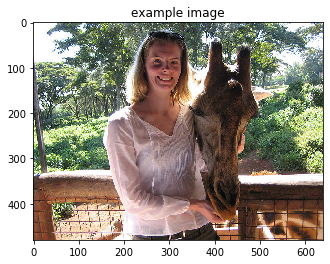

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

orig_image, image ,img_path, caption ,img_id = next(iter(data_loader))

plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

# Evaluation

In [73]:
def clean_sentence(output):
    
    words_sequence = []
    
    for i in output:
        if (i == 1):
            continue
        words_sequence.append(data_loader.dataset.vocab.idx2word[i])
    
    words_sequence = words_sequence[1:-1] 
    sentence = ' '.join(words_sequence) 
    sentence = sentence.capitalize()
    
    return sentence

In [74]:
generator = Generator(embed_size, hidden_size, vocab_size, embed_size, num_layers=2).cpu()
model = os.path.join('scratch', 'models','final_coop-generator-3-25000.pkl')
generator.load_state_dict(torch.load(model))
generator.eval()

encoder = generator.cnn
decoder = generator.rnn


encoder.to(device)
decoder.to(device)


image = image.to(device)
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

output = decoder.sample(features)
sentence = clean_sentence(output)
sentence = sentence.split('.')[0]+ ' . '
print('example sentence:', sentence)
print('example caption:', caption)

example sentence: A woman is holding a giraffe in her mouth . on a tree
example caption: ('A young woman feeds a giraffe at the zoo',)


# Evaluation using BLEU and CIDER score

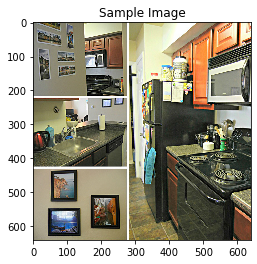

{'testlen': 11, 'reflen': 8, 'guess': [11, 10, 9, 8], 'correct': [1, 0, 0, 0]}
ratio: 1.3749999998281253
The ground truth caption of the image tensor([241645]) : ['Several pictures showing minor details of a home. '] 
The generatred caption of the image tensor([241645]) : ['A kitchen with a stove and a stove top oven . '] 
{'testlen': 11, 'reflen': 8, 'guess': [11, 10, 9, 8], 'correct': [1, 0, 0, 0]}
ratio: 1.3749999998281253


{'Bleu_1': 0.09090909090082655,
 'Bleu_2': 3.015113445489832e-09,
 'Bleu_3': 1.0033557297469764e-11,
 'Bleu_4': 5.960994272631735e-13,
 'ROUGE_L': 0.19551282051282048}

In [75]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

def score(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Rouge(), "ROUGE_L"),
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores

def get_sentence_caption():
    orig_image, image, img_path, caption, img_id = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    return sentence, caption, img_id

sentence, caption, img_id = get_sentence_caption()

sentence = sentence.split('.')[0]+ ' . '


ref = {img_id : [caption[0]]}
hypo = {img_id : [sentence]}

scores = score(ref,hypo)

print(f'The ground truth caption of the image {img_id} : {ref[img_id]} ')
print(f'The generatred caption of the image {img_id} : {hypo[img_id]} ')
score(ref, hypo)